In [1]:
from numpy import genfromtxt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

In [2]:
sentences = pd.read_csv('../data/processed/temple_radio_1_2_sentences_with_translation_bow.csv')
labels = pd.read_csv('../data/processed/labels.csv')

In [3]:
sentences['class'] = 0 #"no_finding"

In [4]:
# [print(l) for l in list(set(list(sentences.Translation))) if l not in list(labels.Labels)]
# [print(l) for l in list(labels.Labels) if l not in list(set(list(sentences.Translation)))]

In [5]:
green = labels[:5]
orange = labels[5:12]
red = labels[12:18]
purple = labels[18:20]

In [6]:
def check_freq(label):
    pos_res = (sentences['Translation'] == label)
    return sentences[pos_res]

In [7]:
green_indexes = []
green_class = []
for label in green.values.tolist():
    result = check_freq(label[0])
    green_indexes.extend(result.index.tolist())
    
green_class = [1 for item in green_indexes]
sentences.loc[green_indexes, 'class'] = green_class

In [8]:
orange_indexes = []
orange_class = []
for label in orange.values.tolist():
    result = check_freq(label[0])
    orange_indexes.extend(result.index.tolist())
    
orange_class = [2 for item in orange_indexes]
sentences.loc[orange_indexes, 'class'] = orange_class

In [9]:
red_indexes = []
red_class = []
for label in red.values.tolist():
    result = check_freq(label[0])
    red_indexes.extend(result.index.tolist())
    
red_class = [3 for item in red_indexes]
sentences.loc[red_indexes, 'class'] = red_class

In [10]:
purple_indexes = []
purple_class = []
for label in purple.values.tolist():
    result = check_freq(label[0])
    purple_indexes.extend(result.index.tolist())
    
purple_class = [4 for item in purple_indexes]
sentences.loc[purple_indexes, 'class'] = purple_class

([<matplotlib.axis.XTick at 0x7f79c0357610>,
 [Text(0, 0, 'No Finding 49.60'),
  Text(0, 0, 'Green 7.60'),
  Text(0, 0, 'Orange 33.60'),
  Text(0, 0, 'Red 7.20'),
  Text(0, 0, 'Purple 2.00')])

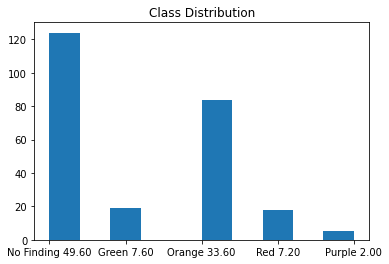

In [11]:
plt.hist(sentences['class'])
plt.title('Class Distribution')
plt.xticks([0, 1, 2, 3, 4], (f"No Finding {(len(sentences[sentences['class'] == 0])/len(sentences) * 100):.2f}", 
                             f"Green {(len(green_indexes)/len(sentences) * 100):.2f}", 
                             f"Orange {(len(orange_indexes)/len(sentences) * 100):.2f}", 
                             f"Red {(len(red_indexes)/len(sentences) * 100):.2f}", 
                             f"Purple {(len(purple_indexes)/len(sentences) * 100):.2f}"))

In [12]:
vectorizer = CountVectorizer(max_features=100)
sentence_embeddings = vectorizer.fit_transform(sentences.Sentence.to_list())

In [26]:
sentences.Sentence[:10].to_list()

['normal contour without focal lesion within limit noncontrast examination.',
 'hepatomegaly.',
 'normal contour.',
 'seen hyperenhancing liver lesion.',
 'liver normal size diffuse hepatic steatosis.',
 'definite suspicious focal mass within limit noncontrast technique.',
 'hepatomegaly.',
 'normal contour enhancement.',
 'cm cyst right hepatic dome.',
 'nodular hepatic surface contour reflecting change cirrhosis.']

In [21]:
sentence_embeddings.toarray()

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [33]:
# dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True))

In [13]:
new_df = pd.DataFrame(sentence_embeddings.toarray())
new_df['class'] = sentences['class']
new_df["sentence"] = sentences.Sentence
new_df['translation'] = sentences.Translation

In [14]:
new_df = new_df.sample(frac=1).reset_index(drop=True)

In [15]:
y = new_df[["class"]]
X = new_df.drop(["class"], axis = 1)

In [18]:
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
i = 0
conf_scores = []
acc_scores = []

for train, test in skf.split(X, y): # Provides train/test indices to split data in train/test sets.
    clf = MultinomialNB().fit(X.drop(["sentence", "translation"], axis = 1).loc[train], y.loc[train].values.ravel())
    y_pred = clf.predict(X.drop(["sentence", "translation"], axis = 1).loc[test])
    
    df_skf = pd.DataFrame(X[['sentence', 'translation']].loc[test])
 
    df_skf['y_true'] = y.loc[test]
    df_skf['pred'] = y_pred
    df_skf.to_csv(f"../data/processed/classification_results/multiclass_naive_result_{i}.csv", index=False)
    acc = accuracy_score(y.loc[test], y_pred)
    acc_scores.append(round(acc, 4))
    conf_scores.append(confusion_matrix(y.loc[test], y_pred))
    i += 1
print(f"confusion matrix score:\n{sum(conf_scores)}\n")
print(acc_scores)

confusion matrix score:
[[107   1  13   3   0]
 [  3   8   7   1   0]
 [ 13   6  64   1   0]
 [  1   1   2  14   0]
 [  1   0   0   0   4]]

[0.8, 0.74, 0.76, 0.84, 0.8]


In [34]:
df = pd.read_csv("../data/processed/classification_results/multiclass_naive_result_0.csv")